# 0. Preparing IDE, Library, Data

**Cài đặt lại môi trường phát triển, import data vào kernel.**

In [ ]:
!pip install scikit-misc
!pip install scikit-learn==0.21.3
!pip install fastai==0.7.0

In [ ]:
import numpy as np 
import pandas as pd 
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv', low_memory=False)
test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv', low_memory=False)
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv', low_memory=False)
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv', low_memory=False)

# 0.1 Preprocessing Bureau and Bureau_Balance table

In [ ]:
grouped = bureau_balance.groupby(['SK_ID_BUREAU'])


In [ ]:
a = pd.DataFrame()
a['SK_ID_BUREAU'] = grouped.groups

In [ ]:
a['MIN_MONTHS_BALANCE'] = grouped['MONTHS_BALANCE'].agg(np.min)
a['SUM_MONTHS_BALANCE'] = grouped['MONTHS_BALANCE'].agg(np.sum)
a['MEAN_MONTHS_BALANCE'] = grouped['MONTHS_BALANCE'].agg(np.mean)
a['SIZE_MONTHS_BALANCE'] = grouped['MONTHS_BALANCE'].agg(np.size)
a['NUM_STATUS_NUMBER'] = grouped['STATUS'].agg(np.size)
a

In [ ]:
bureau = pd.merge(bureau, a, on = 'SK_ID_BUREAU', how='left')

In [ ]:
bureau

In [ ]:
train_cats(bureau)
testt, _, _ = proc_df(bureau, max_n_cat=60)

In [ ]:
grouped = testt.groupby(['SK_ID_CURR'])
bu = pd.DataFrame()
bu['SK_ID_CURR'] = grouped.groups

In [ ]:
col_name = grouped.get_group(100001).columns

In [ ]:
for c in col_name:
    bu['MIN_{0}'.format(c)] = grouped[c].agg(np.min)
    bu['SUM_{0}'.format(c)] = grouped[c].agg(np.sum)
    bu['MEAN_{0}'.format(c)] = grouped[c].agg(np.mean)
    bu['SIZE_{0}'.format(c)] = grouped[c].agg(np.size)

In [ ]:
bu

In [ ]:
bu.reset_index(drop = True, inplace = True)
bu

In [ ]:
bu.to_feather('burea_final')

In [ ]:
train.shape, test.shape

In [ ]:
trainn = pd.merge(train, bu, how='left', on='SK_ID_CURR')
testt = pd.merge(test, bu, how='left', on='SK_ID_CURR')

In [ ]:
trainn.shape, testt.shape

In [ ]:
train = trainn
test = testt

# 1. Examine Data

In [ ]:
print('Training data shape: {}'.format(train.shape))
train.head()

**Training data có 307511 observations và hơn 350 cột với 349 cột features và cột cuối cùng mà chúng ta sẽ phải predict.**

In [ ]:
print('Test data shape: {}'.format(test.shape))
test.head()

**Test Data có 48744 observation và số cột tất nhiên sẽ ít hơn 1 cột so với Training data. Chúng ta sẽ dùng model để predict Test Data rồi thêm các kết quả có được vào cột cuối cùng 350 của Test Data. **

# 2. Examine the distribution of Dependent Variable

In [ ]:
train['TARGET'].value_counts()

In [ ]:
train['TARGET'].plot.hist()

Có thể thấy, sự phân bố của dependent variable (biến ta cần predict) không đồng đều giữa 2 class là rất lớn. Vấn đề đầu tiên mà ta gặp phải là Imbalance Dataset (Skewed Dataset).

# 3. Examine Column Types

In [ ]:
train.dtypes.value_counts()

Dataset có 16 column thuộc dạng Categorical (String).

In [ ]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Một số categorical thuộc dạng có thứ tự Ordinal Categorcal nên ta phải set thứ tự lại của column đó.

In [ ]:
train['NAME_EDUCATION_TYPE'].value_counts()

In [ ]:
train['WEEKDAY_APPR_PROCESS_START'].value_counts()

# 4. Encode Categorical Variable

In [ ]:
train_cats(train)

Chuyển các object column sang category column.

# 5. Order Ordinal Categorical Variable

In [ ]:
train['NAME_EDUCATION_TYPE'].cat.categories

Các variable của NAME_EDUCATION_TYPE chưa nằm trong thứ tự đúng nên ta sẽ set lại thứ tự của biến này.

In [ ]:
train['NAME_EDUCATION_TYPE'].cat.set_categories(['Lower secondary','Secondary / secondary special','Incomplete higher','Higher education','Academic degree'],
                                               ordered = True, inplace = True)

In [ ]:
train['NAME_EDUCATION_TYPE'].cat.categories

In [ ]:
train['WEEKDAY_APPR_PROCESS_START'].cat.set_categories(['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY', 'SATURDAY', 'SUNDAY'],
                                               ordered = True, inplace = True)

In [ ]:
train['WEEKDAY_APPR_PROCESS_START'].cat.categories

In [ ]:
apply_cats(test, train)

# 6. Examine Missing Value

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
X, y, nas = proc_df(train, 'TARGET', max_n_cat=60)
X_test,_,nas = proc_df(test, na_dict=nas,  max_n_cat=60)
X, y, nas = proc_df(train, 'TARGET', na_dict=nas,  max_n_cat=60)

In [ ]:
X.shape, X_test.shape

# 7. First Model

In [ ]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [ ]:
n_valid = 60000
n_trn = len(train)-n_valid
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

Training dataset gồm khoảng hơn 300.000 observations. Nên ta sẽ dùng 20% của training dataset tức 60.000 observations.

In [ ]:
set_rf_samples(100000)
model = RandomForestClassifier(n_jobs=-1, n_estimators=40)
model.fit(X_train, y_train)
print_score(model, X_train, X_valid, y_train, y_valid)

Áp dụng kỹ thuật Bagging của Random Forest với random lấy 100.000 observations cho từng decision tree trong lúc training.

In [ ]:
prediction = model.predict_proba(X_test)[:,1]
submission = pd.DataFrame()
submission['SK_ID_CURR']=X_test.SK_ID_CURR
submission['TARGET']=prediction
submission.to_csv('submission.csv',index=False) # First Model

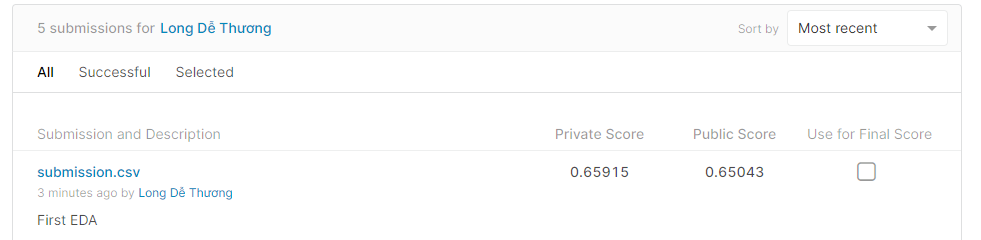

Sau khi đã xử lý missing value và encode categorical variable. Model được chạy thử lần đầu với kết quả khá khả quan đối với tập training. Tuy nhiên, giữa valid_score và submission_score có sự chênh lệch rất lớn. Nên đây là vấn đế thứ 2 mà ta phải giải quyết.

# 8. Remove any unnecesarry features - Random Forest Importance Feature

Dataset hiện có khoảng 682 columns tương ứng 682 features. Việc thực hiện EDA để phân tích các mối liên hệ, pattern trên những feature không cần thiết (hoặc đóng góp rất ít) đến việc prediction là vô cùng lãng phí, tốn thời gian. Nên việc dùng các kỹ thuật ước lượng Feature Importance để loại bỏ các feature không cần thiết trước khi thực hiện EDA, là một việc rất hữu ích. Dưới đây, em sẽ sử dụng Random Forest Feature Importance.

In [ ]:
fi = rf_feat_importance(model, X_train)
fi[:30]

In [ ]:
def plot_fi(fi): 
    return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[fi.imp>0.0095])

In [ ]:
important_col = fi[fi.imp>0.0095].cols
X_train_imp = X_train.copy()
X_valid_imp = X_valid.copy()
X_train_imp = X_train_imp[important_col]
X_valid_imp = X_valid_imp[important_col]
X_train_imp.shape, X_valid_imp.shape 

Từ đây ta sẽ lấy những feature có imp tức importance tác động đến prediction hơn 0.01 - 1%. Tuy nhiên ta cần phải xem xem accuracy của model ngay khi feature selection nhằm chắc chắn rằng, ta không bỏ sai feature nào đó.

In [ ]:
set_rf_samples(100000)
model = RandomForestClassifier(n_jobs=-1, n_estimators=40)
model.fit(X_train_imp, y_train)
print_score(model, X_train_imp, X_valid_imp, y_train, y_valid)

In [ ]:
X_test_imp = X_test.copy()
X_test_imp = X_test_imp[important_col]
prediction = model.predict_proba(X_test_imp)[:,1]
submission = pd.DataFrame()
submission['SK_ID_CURR']=X_test_imp.SK_ID_CURR
submission['TARGET']=prediction
submission.to_csv('submission1.csv',index=False) # Second Model

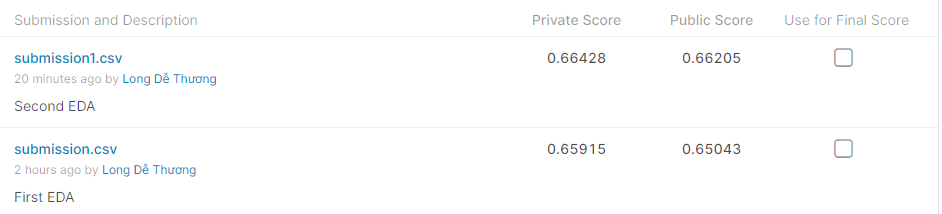

Ta có thể thấy ở trên, rmse lẫn accuracy của model không tăng, lẫn không giảm đáng kể. Đây là một điều đáng mừng khi việc feature selection xuống còn 20 feature không ảnh hưởng nhiều đến rmse, accuracy. Từ đây ta chỉ cần phân tích 20 features này.

In [ ]:
fi = rf_feat_importance(model, X_train_imp)
fi

In [ ]:
plot_fi(fi)

So với sơ đồ Feature Importance cũ ở lần đầu tiên ta đã plot khi so với sơ đồ trên thì tất nhiên có những sự thay đổi đáng kể dễ nhận thấy. Đầu tiên là imp của EXT_SOURCE2 từ 0.046 lên 0.092, imp của EXT_SOURCE3 từ 0.042 lên 0.076, .... 

# 9. Remove any unnecesarry features - Hierachy Correlation Tree

In [ ]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train_imp).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_imp.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

Ta có thể thấy có 2 cặp - 4 features. Có sự tương quan (correlate) với nhau là OBS_30_CNT_SOCIAL_CIRCLE và OBS_60_CNT_SOCIAL_CIRCLE, AMT_GOODS_PRICE và AMT_CREDIT. Ta sẽ thử drop từng feature và train model với từng trường hợp tương ứng để xem trường hợp nào model tăng, giảm.

In [ ]:
def model_score(df_train, df_valid):
    set_rf_samples(100000)
    model = RandomForestClassifier(n_jobs=-1, n_estimators=40)
    model.fit(df_train, y_train)
    print_score(model, df_train, df_valid, y_train, y_valid)

In [ ]:
for c in ['AMT_GOODS_PRICE', 'AMT_CREDIT']:
    print(c)
    temp_train = X_train_imp.drop(c, axis = 1)
    temp_valid = X_valid_imp.drop(c, axis = 1)
    model_score(temp_train, temp_valid)

Việc bỏ các feature giúp model có thể train nhanh hơn đồng thời không tác động nhiều đến accuracy, rmse nên ta sẽ drop 2 biến trên.

In [ ]:
X_train_imp = X_train_imp.drop(['AMT_GOODS_PRICE'], axis = 1)
X_valid_imp = X_valid_imp.drop(['AMT_GOODS_PRICE'], axis = 1)
X_test_imp = X_test_imp.drop(['AMT_GOODS_PRICE'], axis = 1)

# 10. Examine Outliers, Anomaly Variable

In [ ]:
X_train_imp.dtypes.value_counts()

Sau các quá trình chuyển đổi ở trên hiện training set chỉ còn tất cả hai kiểu dữ liệu numeric.

In [ ]:
X_train_imp.select_dtypes('int64').apply(pd.Series.nunique, axis = 0)

Ta sẽ khảo sát các feature thuộc kiểu dữ liệu int64 trước. Feature HOUR_APPR_PROCESS_START gồm 24 giá trị đúng với 24 giờ trong ngày nên hoàn toàn ổn. Hai feature biểu diễn ID là DAYS_ID_PUBLISH và SK_ID_CURR ta sẽ không xét. Vậy ta sẽ xem xét 2 features còn lại.

In [ ]:
(X_train_imp['DAYS_BIRTH'] / 365).describe()

Tuổi nằm trong khoảng (20;69) tuổi nên hoàn toàn bình thường.

In [ ]:
(X_train_imp['DAYS_EMPLOYED'] / 365).describe()

Chúng ta có thể thấy max là 1000. Thực chất có gì sai sai ở đây khi mà số năm làm việc là 1000. Ta sẽ plot thử các giá trị của feature này.

In [ ]:
X_train_imp['DAYS_EMPLOYED'].plot.hist()

In [ ]:
X_test_imp['DAYS_EMPLOYED'].plot.hist()

Phía bên phải chính tức giá trị 365243 là giá trị anomaly, outlier . Ta sẽ gán lại chúng bằng nan. Đồng thời thêm 1 một có giá trị boolean chỉ rằng obervation đó có giá trị anommaly hay không.

In [ ]:
X_train_imp['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace = True)

In [ ]:
X_valid_imp['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace = True)

In [ ]:
X_test_imp['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace = True)

In [ ]:
X_train_imp['DAYS_EMPLOYED'].plot.hist()
X_valid_imp['DAYS_EMPLOYED'].plot.hist()
X_test_imp['DAYS_EMPLOYED'].plot.hist()

In [ ]:
X_train_imp.shape, X_valid_imp.shape, X_test_imp.shape

In [ ]:
X_train_imp = pd.concat([X_train_imp, X_valid_imp])

In [ ]:
X_train_impp, _, nas = proc_df(X_train_imp)
X_test_impp,_ ,nas = proc_df(X_test_imp, na_dict=nas)
X_train_impp, _, nas = proc_df(X_train_imp, na_dict=nas)

In [ ]:
n_valid = 60000
n_trn = len(train)-n_valid
X_train_impp, X_valid_impp = split_vals(X_train_impp, n_trn)

In [ ]:
X_valid_impp['DAYS_EMPLOYED_na'].value_counts()

In [ ]:
set_rf_samples(100000)
model = RandomForestClassifier(n_jobs=-1, n_estimators=40)
model.fit(X_train_impp, y_train)
print_score(model, X_train_impp, X_valid_impp, y_train, y_valid)

In [ ]:
fi = rf_feat_importance(model, X_train_impp)
plot_fi(fi)

In [ ]:
prediction = model.predict_proba(X_test_impp)[:,1]
submission = pd.DataFrame()
submission['SK_ID_CURR']=X_test_impp.SK_ID_CURR
submission['TARGET']=prediction
submission.to_csv('submission2.csv',index=False) # Third Model

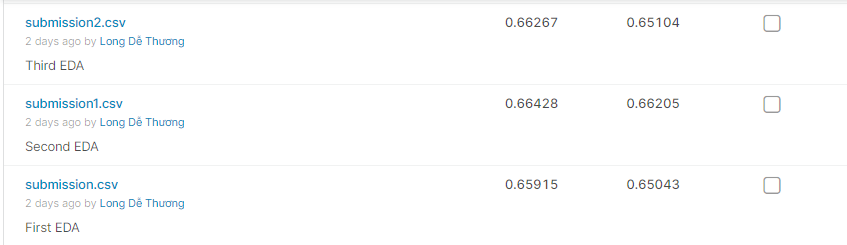


# 11. Extrapolation

In [ ]:
fi = rf_feat_importance(model, X_train_impp)
plot_fi(fi)

Như trên sơ đồ trên, có các biến tăng dần theo thời gian, là biến SK_ID_CURR, DAYS_EMPLOYED, DAYS_ID_PUBLISH, DAYS_REGISTRATION, DAYS_BIRTH. Giả sử dataset được chia theo thứ tự thời gian, thì những biến tăng dần thời gian sẽ mang giá trị mà model chưa thấy bao giờ => Ngoại suy (Extrapolation). Tuy nhiên ta cần phải xem xét liệu dataset có được chia theo thời gian hay không.

In [ ]:
X_train_istest = X_train_impp.copy()
X_valid_istest = X_valid_impp.copy()
X_test_istest = X_test_impp.copy()
X_train_istest['is_test'] = 0
X_valid_istest['is_test'] = 0
X_test_istest['is_test'] = 1

In [ ]:
y_train_istest = X_train_istest['is_test']
y_valid_istest = X_valid_istest['is_test']
y_test_istest = X_test_istest['is_test']

In [ ]:
X_train_istest = X_train_istest.drop('is_test', axis = 1)
X_valid_istest = X_valid_istest.drop('is_test', axis = 1)
X_test_istest = X_test_istest.drop('is_test', axis = 1)

In [ ]:
y_train_istest.shape, y_test_istest.shape

In [ ]:
XX = pd.concat([X_train_istest, X_valid_istest, X_test_istest])
yy = pd.concat([y_train_istest, y_valid_istest, y_test_istest])

In [ ]:
set_rf_samples(100000)
model = RandomForestClassifier(n_jobs=-1, n_estimators=40, oob_score=True)
model.fit(XX, yy)
model.oob_score_

In [ ]:
fi = rf_feat_importance(model, XX)
plot_fi(fi)

Ta có thể thấy 4 biến giúp mô hình phân biệt giữa tập training và test là AMT_ANNUITY, SK_ID_CURR, DAYS_ID_PUBLISH, DAYS_BIRTH. Ta sẽ thử bỏ 1 trong 4 biến này.

In [ ]:
for c in ['MIN_SK_ID_BUREAU','AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'SK_ID_CURR']:
    print(c)
    temp_train = X_train_impp.drop(c, axis = 1)
    temp_valid = X_valid_impp.drop(c, axis = 1)
    model_score(temp_train, temp_valid)

Kết quả trên cho thấy, bỏ đi biến SK_ID_CURR cho ra kết quả tốt nhất

In [ ]:
X_train_final = X_train_impp.drop('MIN_SK_ID_BUREAU', axis = 1)
X_valid_final = X_valid_impp.drop('MIN_SK_ID_BUREAU', axis = 1)
X_test_final = X_test_impp.drop('MIN_SK_ID_BUREAU', axis = 1)

In [ ]:
set_rf_samples(100000)
model = RandomForestClassifier(n_jobs=-1, n_estimators=40)
model.fit(X_train_final, y_train)
print_score(model, X_train_final, X_valid_final, y_train, y_valid)

In [ ]:
submission = pd.DataFrame()
submission['SK_ID_CURR']=X_test_impp.SK_ID_CURR
prediction = model.predict_proba(X_test_final)[:,1]
submission['TARGET']=prediction
submission.to_csv('submission3.csv',index=False) # Fourth Model

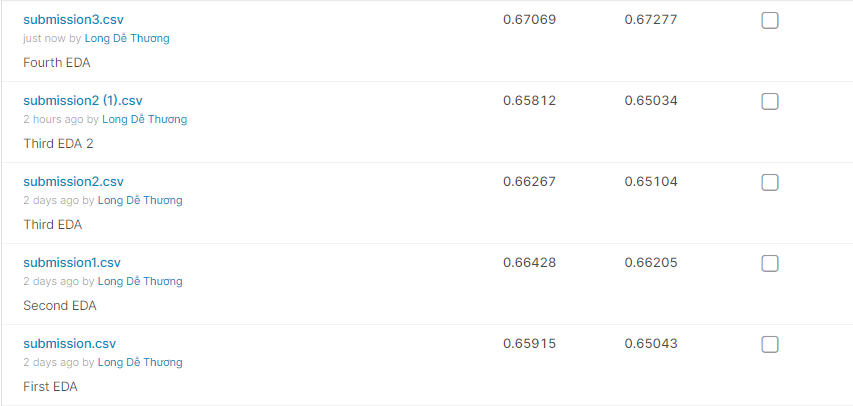

# 12. Random Forest Parameter Tunning

In [ ]:
set_rf_samples(100000)
model = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, min_samples_leaf=3)
model.fit(X_train_final, y_train)
print_score(model, X_train_final, X_valid_final, y_train, y_valid)

In [ ]:
submission = pd.DataFrame()
submission['SK_ID_CURR']=X_test_impp.SK_ID_CURR
prediction = model.predict_proba(X_test_final)[:,1]
submission['TARGET']=prediction
submission.to_csv('submission4.csv',index=False) # Fifth Model

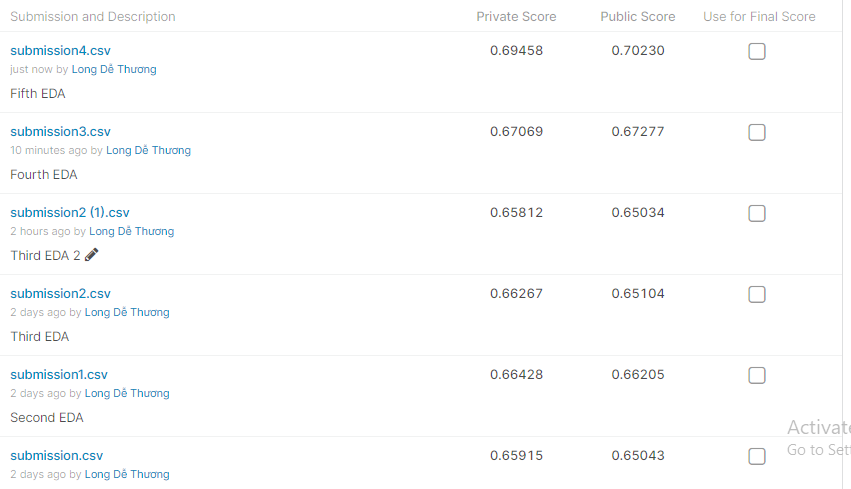

In [ ]:
reset_rf_samples()
model = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_features=0.5, min_samples_leaf=7)
model.fit(X_train_final, y_train)
print_score(model, X_train_final, X_valid_final, y_train, y_valid)

In [ ]:
submission = pd.DataFrame()
submission['SK_ID_CURR']=X_test_impp.SK_ID_CURR
prediction = model.predict_proba(X_test_final)[:,1]
submission['TARGET']=prediction
submission.to_csv('submission5.csv',index=False) # Sixth Model

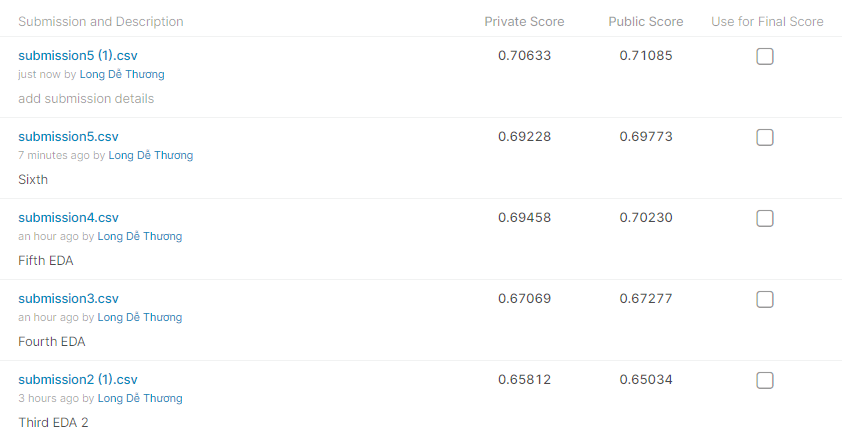